# Imports

In [1]:
# data manipulation
import pandas as pd
import polars as pl
import numpy as np


# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# hypothesis testing
from scipy import stats
from scipy.stats import rankdata
from scipy.stats import wilcoxon, shapiro, ttest_ind, levene, f_oneway, mannwhitneyu
from scipy.stats.mstats import winsorize

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.stattools import medcouple

def cria_colunas(df: pl.DataFrame, tipo_df: str) -> pl.DataFrame:
    df = df.clone()
    map_dict_target = {
        2: "minor",
        3: "minor",
        4: "crititcal",
        5: "major",
        6: "none",
        7: "critical",
        8: "none",
        9: "major",
        10: "minor",
        11: "critical",
        12: "none",
        13: "major"
    }

    def map_values_target(x):
        return map_dict_target.get(x, x)

    df = df.with_columns(
        pl.col(f"{tipo_df}_target").map_elements(map_values_target, return_dtype=pl.String).alias("code_smell_target")
    )

    # mapeando tipo de smell por code snippet
    map_dict_type = {
        2: "long_method",
        3: "data_class",
        4: "feature_envy",
        5: "feature_envy",
        6: "none",
        7: "data_class",
        8: "none",
        9: "long_method",
        10: "feature_envy",
        11: "long_method",
        12: "none",
        13: "data_class"
    }

    def map_values_type(x):
        return map_dict_type.get(x, x)

    df = df.with_columns(
        pl.col(f"{tipo_df}_target").map_elements(map_values_type, return_dtype=pl.String).alias("code_smell_type")
    )

    return df

# Lendo os dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
fixation = pd.read_csv(r'/content/drive/MyDrive/fixation_geral/all_exp_fixations_original2.csv',
                       sep='\t',
                       usecols=['fixation_target', 'source_file_line', 'event', 'experiment', 'duration', 'date_hour', 'system_time'])
fixation = cria_colunas(pl.DataFrame(fixation), 'fixation').to_pandas()
print(fixation.shape)
fixation.head()

(76940, 9)


,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,long_method
1,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,long_method
2,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,long_method
3,2,77,1697813304400,97,2023-10-20T11:48:24.400000000,top-down-inside,1,minor,long_method
4,2,81,1697813304546,370,2023-10-20T11:48:24.546000000,top-down-inside,1,minor,long_method


In [4]:
answers_data_class = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Data Class')
answers_data_class['What code smell(s)?'] = 'Data Class'
answers_long_method = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Long Method')
answers_long_method['What code smell(s)?'] = 'Long Method'
answers_feature_envy = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Feature Envy')
answers_feature_envy['What code smell(s)?'] = 'Feature Envy'
answers_none = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'None')
answers_none['What code smell(s)?'] = 'None'
answers_others = pd.read_excel(r'/content/drive/MyDrive/respostas/V2 Respostas Questionário - Exploring Physiological Metrics in Software Development.xlsx', 'Others')
answers_none['What code smell(s)?'] = 'None'
answers_others['What code smell(s)?'] = 'Other'


answers = {'data_class': answers_data_class,
           'long_method': answers_long_method,
           'feature_envy': answers_feature_envy,
           'none': answers_none,
           'others': answers_others}

In [5]:
fixation.isna().sum()

,0
fixation_target,0
source_file_line,0
system_time,0
duration,0
date_hour,0
event,0
experiment,0
code_smell_target,0
code_smell_type,0


## Definido as seções

In [6]:
def define_secoes(row, num_lines):
    todo_codigo = list(range(1, num_lines+1))
    secoes = [todo_codigo[i:i+3] for i in range(0, len(todo_codigo ), 3)]
    for indice, secao in enumerate(secoes):
        if secao[0] <= row <= secao[-1]:  # Verifica se o número está dentro do intervalo da seção
            return indice + 1  # Retorna a seção (começando de 1)
    return None

In [7]:
num_lines = {
    2: 98,
    3: 41,
    4: 205,
    5: 398,
    6: 169,
    7: 56,
    8: 53,
    9: 2957,
    10: 852,
    11: 684,
    12: 667,
    13: 1148
}

for code in fixation['fixation_target'].unique():
    fixation.loc[fixation['fixation_target'] == code, 'section'] = fixation.loc[fixation['fixation_target'] == code, 'source_file_line'].apply(lambda x: define_secoes(x, num_lines[code]))

fixation['section'] = fixation['section'].astype(int)
fixation.head()

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,long_method,26
1,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,long_method,29
2,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,long_method,28
3,2,77,1697813304400,97,2023-10-20T11:48:24.400000000,top-down-inside,1,minor,long_method,26
4,2,81,1697813304546,370,2023-10-20T11:48:24.546000000,top-down-inside,1,minor,long_method,27


## Juntando fixation com as respostas

In [8]:
answers_df = pd.DataFrame()

for smell_type, df in answers.items():
    answers_df = pd.concat([answers_df, df])

In [9]:
answers_df[answers_df.duplicated(subset=['experiment_id', 'code_snippet'])]

,experiment_id,code_snippet,"Please, describe how the code snippets works.",Is the analyzed code snippets hard to comprehend?,"Based on the previous answer, explain why.",Is there a code smell in the analyzed code snippet?,What code smell(s)?,What is the code smell severity?,What was your reason for choosing this severity?,How did you feel during the analysis of this code snippet? (1 for very uncomfortable to 5 for very comfortable).
5,11,2,O nome do método não fala muito sobre seu obje...,No,É um código de complexidade muito grande para ...,Yes,Long Method,Critical,manutenção de curto e longo prazo,5
14,11,4,Código sujo e não seguindo um padrão de decodi...,Yes,"Não entendi muito bem o código, mas pelo nome ...",Yes,Long Method,Critical,difícil entendimento,3
18,11,5,"Comentário desnecessário, se o meu código não ...",Yes,Tá fazendo algumas coisas de difícil entendime...,Yes,Long Method,Critical,complexidade grande para investigações em prod...,3
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Long Method,Critical,"A função cria diversas variáveis, o que poderi...",2
44,11,11,Método faz muita coisa. \npassa um path de for...,Yes,"não entendi nada, por isso é difícil, tem muit...",Yes,Long Method,Critical,"não coloque em prod, esse método é complexo de...",5
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Feature Envy,Major,O método poderia ser dividido em dois: O prime...,5
2,11,2,O nome do método não fala muito sobre seu obje...,No,É um código de complexidade muito grande para ...,Yes,Feature Envy,Critical,manutenção de curto e longo prazo,5
4,16,2,O método recebe uma string e cria um arquivo c...,Yes,"O código não é de fácil compreensão, por algun...",Yes,Feature Envy,Minor,"Pois apesar de ser problemático, não é algo qu...",4
5,19,2,Escreve um arquivo que tem como nome o diretór...,Yes,"É um método um pouco longo, que faz duas funçõ...",Yes,Feature Envy,Major,Os code smells vão dificultar bastante o enten...,2
7,11,3,"Número mágico, poderia ter método get e set, o...",Yes,"Ferindo fatores importantes da POO, encapsulam...",Yes,Feature Envy,Major,aceitável dependendo do contexto do código,5


In [10]:
answers_df[answers_df['experiment_id'] == 1]

,experiment_id,code_snippet,"Please, describe how the code snippets works.",Is the analyzed code snippets hard to comprehend?,"Based on the previous answer, explain why.",Is there a code smell in the analyzed code snippet?,What code smell(s)?,What is the code smell severity?,What was your reason for choosing this severity?,How did you feel during the analysis of this code snippet? (1 for very uncomfortable to 5 for very comfortable).
28,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Data Class,Critical,"A função cria diversas variáveis, o que poderi...",2
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Long Method,Major,O método poderia ser dividido em dois: O prime...,5
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Long Method,Critical,"A função cria diversas variáveis, o que poderi...",2
39,1,11,A função retorna uma lista ordenada com os Ids...,No,Apesar de possuir diversos condicionais a lógi...,Yes,Long Method,Major,É um método longo que poderia ser simplificado...,4
0,1,2,O método cria um arquivo dentro de um diretóri...,No,Apesar de possuir diversas chamadas de métodos...,Yes,Feature Envy,Major,O método poderia ser dividido em dois: O prime...,5
10,1,5,A função verifica o tipo de instância dos obje...,No,"Apesar da recursão, o código é de simples ente...",Yes,Feature Envy,Critical,A recursividade pode causar um alto custo comp...,3
25,1,9,A função descobre hosts dentro de determinado ...,Yes,A função tem uma série de variáveis e verifica...,Yes,Feature Envy,Critical,"A função cria diversas variáveis, o que poderi...",2
8,1,3,O código apresenta uma classe com seus atribut...,No,É um classe simples com poucas linhas de códig...,No,None,NaN,NaN,5
19,1,4,A função cria uma instância de um objeto com v...,No,É um código de simples entendimento pois cria ...,No,None,NaN,NaN,4
40,1,6,A função troca um delimitador dentro de uma st...,No,É uma função simples de formatação de strings.,No,None,NaN,NaN,4


In [11]:
# answers_df = answers_df.drop_duplicates(subset=['experiment_id', 'code_snippet'])

In [12]:
fix = fixation.merge(answers_df[['What code smell(s)?', 'code_snippet', 'experiment_id']], left_on=['experiment', 'fixation_target'], right_on=['experiment_id', 'code_snippet'], how='left')

In [13]:
display(fix.isna().sum().to_frame())

fix[fix.isna().any(axis=1)]

,0
fixation_target,0
source_file_line,0
system_time,0
duration,0
date_hour,0
event,0
experiment,0
code_smell_target,0
code_smell_type,0
section,0


,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id
564,12,563,1697815187526,150,2023-10-20T12:19:47.526000000,top-down-inside,1,none,none,188,NaN,NaN,NaN
565,12,561,1697815187716,140,2023-10-20T12:19:47.716000000,top-down-inside,1,none,none,187,NaN,NaN,NaN
566,12,563,1697815192595,357,2023-10-20T12:19:52.595000000,top-down-inside,1,none,none,188,NaN,NaN,NaN
567,12,563,1697815193002,153,2023-10-20T12:19:53.002000000,bottom-up-inside,1,none,none,188,NaN,NaN,NaN
568,12,563,1697815193196,165,2023-10-20T12:19:53.196000000,bottom-up-inside,1,none,none,188,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14890,12,563,1703006411036,1410,2023-12-19T14:20:11.036000000,bottom-up-inside,7,none,none,188,NaN,NaN,NaN
14891,13,966,1703006591545,136,2023-12-19T14:23:11.545000000,top-down-outside,7,major,data_class,322,NaN,NaN,NaN
14892,13,963,1703006592947,127,2023-12-19T14:23:12.947000000,bottom-up-outside,7,major,data_class,321,NaN,NaN,NaN
14893,13,953,1703006751306,109,2023-12-19T14:25:51.306000000,top-down-outside,7,major,data_class,318,NaN,NaN,NaN


In [14]:
fix['experiment'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 23, 24, 25, 26, 27])

In [15]:
fix[fix.isna().any(axis=1)]['experiment'].unique()

array([1, 2, 7])

In [16]:
fix = fix.dropna()

In [17]:
fix = fix.copy()
fix['code_smell_type'] = fix.loc[:, 'code_smell_type'].str.replace('_', ' ').str.title()

In [18]:
fix['mental_model'] = fix['event'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])

In [19]:
fix.head()

,fixation_target,source_file_line,system_time,duration,date_hour,event,experiment,code_smell_target,code_smell_type,section,What code smell(s)?,code_snippet,experiment_id,mental_model
0,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Long Method,2.0,1.0,top-down
1,2,77,1697813303583,107,2023-10-20T11:48:23.583000000,top-down-inside,1,minor,Long Method,26,Feature Envy,2.0,1.0,top-down
2,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Long Method,2.0,1.0,top-down
3,2,86,1697813303759,157,2023-10-20T11:48:23.759000000,top-down-inside,1,minor,Long Method,29,Feature Envy,2.0,1.0,top-down
4,2,83,1697813303966,374,2023-10-20T11:48:23.966000000,bottom-up-inside,1,minor,Long Method,28,Long Method,2.0,1.0,bottom-up


## Retirando outliers

In [20]:
# result_df = pd.DataFrame(columns=['experiment_id', 'code_snippet', 'duration', 'What code smell(s)?', 'mental_model', 'code_smell_type', 'source_file_line', 'section', 'event'])

# known_terms = ['Long Method', 'Data Class', 'Feature Envy', 'None']

# long_method_res = []
# data_class_res = []
# feature_envy_res = []
# none_res = []
# others_res = []

# for index, row in fix.iterrows():
#     experiment, code_snippet = row['experiment_id'], row['code_snippet']
#     res = answers_df.loc[(answers_df['experiment_id'] == experiment) & (answers_df['code_snippet'] == code_snippet), 'What code smell(s)?']
#     # print(res.values[0])
#     # break

#     # print(res.values)

#     # separando para caso tiver mais de um code smell
#     smells_type_res = res.values[0].split(', ')
#     # print([s for s in smells_type_res])

#     for s in smells_type_res:
#         if s == '':
#             continue
#         if 'Long Method' in s:
#             if 73.963 <= row['duration'] <= 2428.371:
#                 long_method_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Long Method', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'Data Class' in s:
#             if 79.464 <= row['duration'] <= 3072.444:
#                 data_class_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Data Class', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'Feature Envy' in s:
#             if 77.030 <= row['duration'] <= 2487.983:
#                 feature_envy_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  'Feature Envy', row['mental_model'],
#                                                  row['code_smell_type'], row['source_file_line'], row['section'], row['event']]
#         if 'None' in s:
#             if 60.484 <= row['duration'] <= 2430.436:
#                 none_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'], 'None',
#                                                  row['mental_model'], row['code_smell_type'],
#                                                  row['source_file_line'], row['section'], row['event']]
#         if any(term not in known_terms for term in s.split(', ')) or 'Others' in s:
#             if 69.531 <= row['duration'] <= 2294.185:
#                 others_res.append(row['duration'])
#                 result_df.loc[len(result_df)] = [experiment, code_snippet, row['duration'],
#                                                  "Other", row['mental_model'], row['code_smell_type'],
#                                                  row['source_file_line'], row['section'], row['event']]
#             break

# result_df.to_csv('all_exp_fixation_treated_by_response.csv', index=False)

In [21]:
result_df = pd.read_csv(r'/content/drive/MyDrive/fixation_geral/all_exp_fixation_treated_by_response.csv', na_values=[''], keep_default_na=False)

result_df.head()

,experiment_id,code_snippet,duration,What code smell(s)?,mental_model,code_smell_type,source_file_line,section,event
0,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside
1,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside
2,1.0,2.0,107,Long Method,top-down,Long Method,77,26,top-down-inside
3,1.0,2.0,107,Feature Envy,top-down,Long Method,77,26,top-down-inside
4,1.0,2.0,157,Long Method,top-down,Long Method,86,29,top-down-inside


In [22]:
fix['classified_as_smell'] = fix['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [23]:
result_df.shape

(90829, 9)

In [24]:
result_df.isna().sum()

,0
experiment_id,0
code_snippet,0
duration,0
What code smell(s)?,0
mental_model,0
code_smell_type,0
source_file_line,0
section,0
event,0


In [25]:
result_df['classified_as_smell'] = result_df['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [26]:
result_df.classified_as_smell.value_counts()

,count
classified_as_smell,
True,59021
False,31808


## Tratando outliers - Winsorize

In [27]:
long_method_res = fix.loc[fix['What code smell(s)?'] == 'Long Method', 'duration'].values
data_class_res = fix.loc[fix['What code smell(s)?'] == 'Data Class', 'duration'].values
feature_envy_res = fix.loc[fix['What code smell(s)?'] == 'Feature Envy', 'duration'].values
none_res = fix.loc[fix['What code smell(s)?'] == 'None', 'duration'].values
others_res = fix.loc[fix['What code smell(s)?'] == 'Other', 'duration'].values

In [28]:
def adjusted_boxplot(data):
    # Primeiro, ordene os dados
    data = np.sort(data)

    # Calcule o primeiro e terceiro quartis (Q1 e Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Calcule a skewness Medcouple (MC)
    MC = medcouple(data)

    # Fator de ajuste para os limites superior e inferior
    if MC > 0:  # Skewness positiva
        lower_limit = Q1 - 1.5 * np.exp(-4 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(3 * MC) * IQR
    elif MC < 0:  # Skewness negativa
        lower_limit = Q1 - 1.5 * np.exp(-3 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(4 * MC) * IQR
    else:  # Distribuição simétrica
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

    # Identificar outliers com base nos limites ajustados
    outliers = data[(data < lower_limit) | (data > upper_limit)]
    non_outliers = data[(data >= lower_limit) & (data <= upper_limit)]

    return lower_limit, upper_limit, outliers, non_outliers

lower_limit_lm, upper_limit_lm, outliers_lm, non_outliers_lm = adjusted_boxplot(long_method_res)

lm = pd.DataFrame(index=['long_method' for i in range(len(long_method_res))], data=long_method_res).reset_index()
lm.columns = ['smells_type', 'duration']

lower_limit_dc, upper_limit_dc, outliers_dc, non_outliers_dc = adjusted_boxplot(data_class_res)

dc = pd.DataFrame(index=['data_class' for i in range(len(data_class_res))], data=data_class_res).reset_index()
dc.columns = ['smells_type', 'duration']

lower_limit_fe, upper_limit_fe, outliers_fe, non_outliers_fe = adjusted_boxplot(feature_envy_res)

fe = pd.DataFrame(index=['feature_envy' for i in range(len(feature_envy_res))], data=feature_envy_res).reset_index()
fe.columns = ['smells_type', 'duration']

lower_limit_no, upper_limit_no, outliers_no, non_outliers_no = adjusted_boxplot(none_res)

no = pd.DataFrame(index=['none' for i in range(len(none_res))], data=none_res).reset_index()
no.columns = ['smells_type', 'duration']

lower_limit_others, upper_limit_others, outliers_others, non_outliers_others = adjusted_boxplot(others_res)

others = pd.DataFrame(index=['others' for i in range(len(others_res))], data=others_res).reset_index()
others.columns = ['smells_type', 'duration']

In [29]:
print(f'long_method lower limit: {float(lower_limit_lm):.3f}, long_method upper limit: {float(upper_limit_lm):.3f}')

print(f'data_class lower limit: {float(lower_limit_dc):.3f}, data_class upper limit: {float(upper_limit_dc):.3f}')

print(f'feature_envy lower limit: {float(lower_limit_fe):.3f}, feature_envy upper limit: {float(upper_limit_fe):.3f}')

print(f'none lower limit: {float(lower_limit_no):.3f}, none upper limit: {float(upper_limit_no):.3f}')

print(f'others lower limit: {float(lower_limit_others):.3f}, others upper limit: {float(upper_limit_others):.3f}')

long_method lower limit: 73.963, long_method upper limit: 2428.371
data_class lower limit: 79.385, data_class upper limit: 3058.695
feature_envy lower limit: 77.030, feature_envy upper limit: 2487.983
none lower limit: 60.484, none upper limit: 2430.436
others lower limit: 68.443, others upper limit: 2280.050


In [30]:
fix['duration'] = fix['duration'].astype(float)
fix.loc[fix['What code smell(s)?'] == "Long Method", "duration"] = fix.loc[fix['What code smell(s)?'] == "Long Method", "duration"].clip(lower=73.963, upper=2428.371)
fix.loc[fix['What code smell(s)?'] == "Data Class", "duration"] = fix.loc[fix['What code smell(s)?'] == "Data Class", "duration"].clip(lower=79.385, upper=3058.695)
fix.loc[fix['What code smell(s)?'] == "Feature Envy", "duration"] = fix.loc[fix['What code smell(s)?'] == "Feature Envy", "duration"].clip(lower=77.030, upper=2487.983)
fix.loc[fix['What code smell(s)?'] == "None", "duration"] = fix.loc[fix['What code smell(s)?'] == "None", "duration"].clip(lower=60.484, upper=2430.436)
fix.loc[fix['What code smell(s)?'] == "Other", "duration"] = fix.loc[fix['What code smell(s)?'] == "Other", "duration"].clip(lower=68.443, upper=2280.050)

# fix_response.loc[fix_response['What code smell(s)?'] == "Long Method", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Long Method", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "Data Class", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Data Class", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "Feature Envy", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "Feature Envy", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] == "None", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] == "None", "duration"], (0.025, 0.025))
# fix_response.loc[fix_response['What code smell(s)?'] != "None", "duration"] = winsorize(fix_response.loc[fix_response['What code smell(s)?'] != "None", "duration"], (0.025, 0.025))

In [31]:
fix['classified_as_smell'] = fix['What code smell(s)?'].apply(lambda x: True if x != 'None' else False)

In [32]:
fix_response = fix.copy()

# RQ2

1. - Coletar dados:

Fixation Count e AFD: Capturar o número de fixações (Fixation Count) e a duração média das fixações (Average Fixation Duration) para cada trecho de código, conforme analisado pelos participantes.
Tempo Total de Análise: Registrar o tempo total gasto pelos desenvolvedores na análise de cada trecho de código, conforme identificado como contendo ou não code smells pelos participantes.
Respostas dos Participantes: Coletar as respostas dos participantes sobre a presença e severidade dos code smells identificados.

2. - Esforço Cognitivo:

Métrica Combinada: Multiplicar o Fixation Count pela Average Fixation Duration (AFD) para obter uma medida do esforço cognitivo para cada trecho de código.
Comparação entre Trechos com e sem Code Smells: Comparar essa métrica entre trechos de código que os participantes identificaram como contendo code smells e aqueles que não identificaram.

3. - Análise Quantitativa:

Correlação: Realizar análises de correlação para verificar se há uma relação significativa entre o esforço cognitivo medido (Fixation Count x AFD) e a presença de code smells, conforme percebido pelos participantes.
Análise Comparativa de Tempo: Calcular o tempo médio gasto na análise de trechos de código identificados pelos participantes como contendo ou não code smells e realizar testes estatísticos (e.g., t-test) para identificar diferenças significativas.

4. - Visualizar dados:

Gráficos de Barras e Boxplots: Utilizar gráficos de barras ou boxplots para comparar o esforço cognitivo e o tempo médio de análise entre trechos identificados como contendo ou não code smells pelos participantes.
Gráficos de Dispersão: Criar gráficos de dispersão para ilustrar a relação entre o esforço cognitivo medido e a presença de code smells, conforme identificados pelos participantes.

## Preparando os dados

In [33]:
result_df_grouped = fix_response.groupby(['What code smell(s)?', 'experiment_id', 'code_snippet'])['duration'].agg(['mean', 'count'])

In [34]:
len(result_df_grouped)

314

In [35]:
result_df_grouped['afd*fc'] = result_df_grouped[('mean')] * result_df_grouped[('count')]

In [36]:
long_method_afd_fc = result_df_grouped.loc['Long Method', 'afd*fc']
data_class_afd_fc = result_df_grouped.loc['Data Class', 'afd*fc']
feature_envy_afd_fc = result_df_grouped.loc['Feature Envy', 'afd*fc']
none_afd_fc = result_df_grouped.loc['None', 'afd*fc']
others_afd_fc = result_df_grouped.loc['Other', 'afd*fc']

## Verificando assimetria

In [37]:
assimetria_lm_med = medcouple(long_method_afd_fc)
assimetria_dc_med = medcouple(data_class_afd_fc)
assimetria_fe_med = medcouple(feature_envy_afd_fc)
assimetria_no_med = medcouple(none_afd_fc)
assimetria_others_med = medcouple(others_afd_fc)

print(f"Assimetria (Medcouple) de Long Method: {assimetria_lm_med}")
print(f"Assimetria (Medcouple) de Data Class: {assimetria_dc_med}")
print(f"Assimetria (Medcouple) de Feature Envy: {assimetria_fe_med}")
print(f"Assimetria (Medcouple) de None: {assimetria_no_med}")
print(f"Assimetria (Medcouple) de Others: {assimetria_others_med}")

Assimetria (Medcouple) de Long Method: 0.10923998928830987
Assimetria (Medcouple) de Data Class: -0.06035183709870735
Assimetria (Medcouple) de Feature Envy: 0.020044405233149664
Assimetria (Medcouple) de None: 0.14263798440116482
Assimetria (Medcouple) de Others: 0.1735413989022495


## Dados assimétricos, logo, usa-se o Adjusted Boxplot

In [38]:
def adjusted_boxplot(data):
    # Primeiro, ordene os dados
    data = np.sort(data)

    # Calcule o primeiro e terceiro quartis (Q1 e Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Calcule a skewness Medcouple (MC)
    MC = medcouple(data)

    # Fator de ajuste para os limites superior e inferior
    if MC > 0:  # Skewness positiva
        lower_limit = Q1 - 1.5 * np.exp(-4 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(3 * MC) * IQR
    elif MC < 0:  # Skewness negativa
        lower_limit = Q1 - 1.5 * np.exp(-3 * MC) * IQR
        upper_limit = Q3 + 1.5 * np.exp(4 * MC) * IQR
    else:  # Distribuição simétrica
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

    # Identificar outliers com base nos limites ajustados
    outliers = data[(data < lower_limit) | (data > upper_limit)]
    non_outliers = data[(data >= lower_limit) & (data <= upper_limit)]

    return lower_limit, upper_limit, outliers, non_outliers

lower_limit_lm, upper_limit_lm, outliers_lm, non_outliers_lm = adjusted_boxplot(long_method_afd_fc)

lm = pd.DataFrame(index=['long_method' for i in range(len(long_method_afd_fc))], data=long_method_afd_fc.values).reset_index()
lm.columns = ['smells_type', 'afd_fc']

lower_limit_dc, upper_limit_dc, outliers_dc, non_outliers_dc = adjusted_boxplot(data_class_afd_fc)

dc = pd.DataFrame(index=['data_class' for i in range(len(data_class_afd_fc))], data=data_class_afd_fc.values).reset_index()
dc.columns = ['smells_type', 'afd_fc']

lower_limit_fe, upper_limit_fe, outliers_fe, non_outliers_fe = adjusted_boxplot(feature_envy_afd_fc)

fe = pd.DataFrame(index=['feature_envy' for i in range(len(feature_envy_afd_fc))], data=feature_envy_afd_fc.values).reset_index()
fe.columns = ['smells_type', 'afd_fc']

lower_limit_no, upper_limit_no, outliers_no, non_outliers_no = adjusted_boxplot(none_afd_fc)

no = pd.DataFrame(index=['none' for i in range(len(none_afd_fc))], data=none_afd_fc.values).reset_index()
no.columns = ['smells_type', 'afd_fc']

lower_limit_others, upper_limit_others, outliers_others, non_outliers_others = adjusted_boxplot(others_afd_fc )

others = pd.DataFrame(index=['others' for i in range(len(others_afd_fc ))], data=others_afd_fc.values).reset_index()
others.columns = ['smells_type', 'afd_fc']

smells_afd_fc_res = pd.concat([lm, dc, fe, no, others])

adjusted_limits = {
    'data_class': {'lower': lower_limit_dc, 'upper': upper_limit_dc},
    'feature_envy': {'lower': lower_limit_fe, 'upper': upper_limit_fe},
    'none': {'lower': lower_limit_no, 'upper': upper_limit_no},
    'others': {'lower': lower_limit_others, 'upper': upper_limit_others},
    'long_method': {'lower': lower_limit_lm, 'upper': upper_limit_lm}
}

filtered_data = pd.DataFrame()  # Criar um DataFrame vazio para armazenar os dados filtrados

for smell, limits in adjusted_limits.items():
    lower, upper = limits['lower'], limits['upper']
    smell_data = smells_afd_fc_res[
        (smells_afd_fc_res['smells_type'] == smell) &
        (smells_afd_fc_res['afd_fc'] >= lower) &
        (smells_afd_fc_res['afd_fc'] <= upper)
    ]
    filtered_data = pd.concat([filtered_data, smell_data])

In [39]:
upper_limit_lm, upper_limit_dc, upper_limit_fe, upper_limit_no, upper_limit_others

(361399.6787712041,
 187267.43447730155,
 292605.82193726255,
 282473.3157492707,
 485497.46396130713)

In [40]:
len(filtered_data)

301

## Comparar essa métrica (Fixation Count * Average Fixation Duration (AFD)) entre trechos de código que os participantes identificaram como contendo code smells e aqueles que não identificaram.

In [41]:
duration_metrics = fix_response.groupby(['classified_as_smell', 'experiment_id', 'code_snippet']).agg({'duration': ['mean', 'count']})
duration_metrics['afd*fc'] = duration_metrics[('duration', 'mean')] * duration_metrics[('duration', 'count')]
duration_metrics.head()

duration           afd*fc
                                                      mean count           
classified_as_smell experiment_id code_snippet                             
False               1.0           3.0           842.489333    12  10109.872
                                  4.0           642.036333    12   7704.436
                                  6.0           566.429217    23  13027.872
                                  7.0           339.750000    16   5436.000
                                  8.0           244.080000    25   6102.000

In [42]:
fix_response.loc[(fix_response['experiment_id'] == 1) & (fix_response['code_snippet'] == 3)].duration.mean()

842.4893333333333

In [43]:
duration_metrics_smell = duration_metrics.loc[True]
duration_metrics_no_smell = duration_metrics.loc[False]

In [44]:
duration_metrics.shape

(295, 3)

In [45]:
no_smell_afd_fc = duration_metrics_no_smell['afd*fc'].values
smell_afd_fc = duration_metrics_smell ['afd*fc'].values

In [46]:
print("Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell'", no_smell_afd_fc.mean())
print("Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell'", smell_afd_fc.mean())

print("Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell'", no_smell_afd_fc.var())
print("Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell'", smell_afd_fc.var())

Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell' 104153.29213513514
Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell' 152853.96169387756
Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell' 8870557866.045107
Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell' 16887586209.873974


### Teste para verificar igualdade de variância

    H0: Não há diferenças significativas na variância da métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que foram
    identificados como smell e códigos não identificados como smell.

    H1: Há diferenças significativas na variância da métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que
    foram identificados como smell e códigos não identificados como smell.

In [47]:
statistic, pvalue = levene(no_smell_afd_fc, smell_afd_fc)

print(f"stat: {statistic}")
print(f"pvalue: {pvalue}")

alpha = 0.05

if pvalue < alpha:
    print("H0 rejeitada. As variâncias são diferentes.")
else:
    print("H0 não rejeitada. As variâncias são iguais.")

stat: 5.62802725262751
pvalue: 0.018321258807938726
H0 rejeitada. As variâncias são diferentes.


### Teste para verificar a diferença:

    H0: Não há diferenças significativas na métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que foram
    identificados como smell e códigos não identificados como smell.

    H1: Há diferenças significativas na métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que
    foram identificados como smell e códigos não identificados como smell.

In [48]:
# statistic, pvalue = ttest_ind(smell_afd_fc, no_smell_afd_fc)
statistic, pvalue = mannwhitneyu(smell_afd_fc, no_smell_afd_fc)

print(f"t-statistic: {statistic}")
print(f"p-value: {pvalue}")

alpha = 0.05

if pvalue < alpha:
    print("H0 rejeitada. Há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.")
else:
    print("H0 não rejeitada. Não há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.")


t-statistic: 14025.0
p-value: 1.7453833504173623e-05
H0 rejeitada. Há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.


## Utilizando winsorize

In [49]:
smells_afd_fc_res.head()

,smells_type,afd_fc
0,long_method,31721.742
1,long_method,29731.742
2,long_method,13080.371
3,long_method,116306.742
4,long_method,57095.371


In [50]:
long_method_treated = smells_afd_fc_res[smells_afd_fc_res["smells_type"] == "long_method"]["afd_fc"].clip(lower=lower_limit_lm, upper=upper_limit_lm)
data_class_treated = smells_afd_fc_res[smells_afd_fc_res["smells_type"] == "data_class"]["afd_fc"].clip(lower=lower_limit_dc, upper=upper_limit_dc)
feature_envy_treated = smells_afd_fc_res[smells_afd_fc_res["smells_type"] == "feature_envy"]["afd_fc"].clip(lower=lower_limit_fe, upper=upper_limit_fe)
none_treated = smells_afd_fc_res[smells_afd_fc_res["smells_type"] == "none"]["afd_fc"].clip(lower=lower_limit_no, upper=upper_limit_no)
others_treated = smells_afd_fc_res[smells_afd_fc_res["smells_type"] == "others"]["afd_fc"].clip(lower=lower_limit_others, upper=upper_limit_others)

In [51]:
upper_limit_others

485497.46396130713

In [52]:
others_treated.max()

442145.4

In [53]:
long_method_treated.max()

361399.6787712041

In [54]:
no_smell_afd_fc = none_treated.values
smell_afd_fc = np.concatenate([long_method_treated, data_class_treated, feature_envy_treated, others_treated])

In [55]:
print("Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell'", no_smell_afd_fc.mean())
print("Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell'", smell_afd_fc.mean())

print("Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell'", no_smell_afd_fc.var())
print("Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell'", smell_afd_fc.var())

Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell' 97936.94153037584
Média de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell' 130825.94382113735
Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Não Smell' 4122187045.0505023
Variância de (Fixation Count * Average Fixation Duration (AFD)) para códigos que foram classificados como 'Smell' 7211950828.3029785


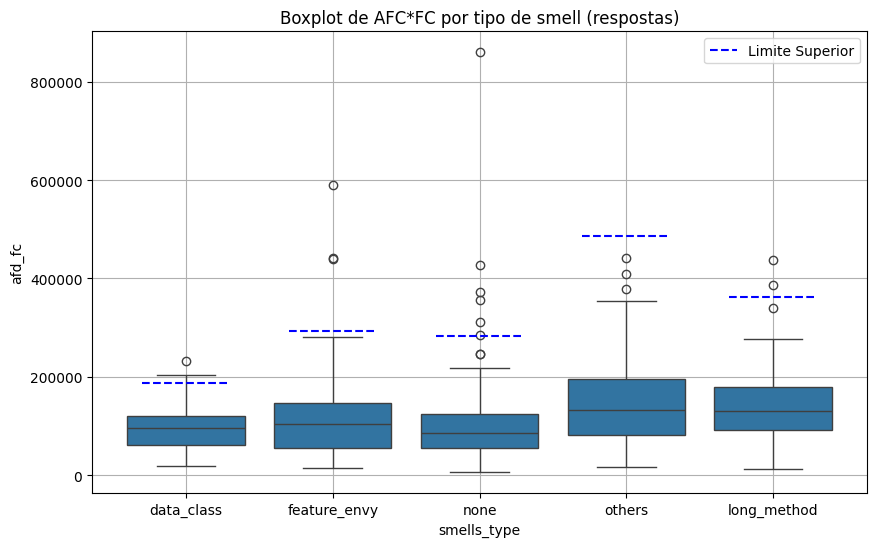

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='smells_type', y='afd_fc', data=smells_afd_fc_res, order=['data_class', 'feature_envy', 'none', 'others', 'long_method'])
plt.title('Boxplot de AFC*FC por tipo de smell (respostas)')
plt.grid()

for i, smell in enumerate(['data_class', 'feature_envy', 'none', 'others', 'long_method']):
    upper = adjusted_limits[smell]['upper']

    # Adiciona as linhas de limite ajustado
    ax.hlines(y=upper, xmin=i - 0.3, xmax=i + 0.3, colors='blue', linestyles='--', label='Limite Superior' if i == 0 else "")

plt.legend()

plt.show()

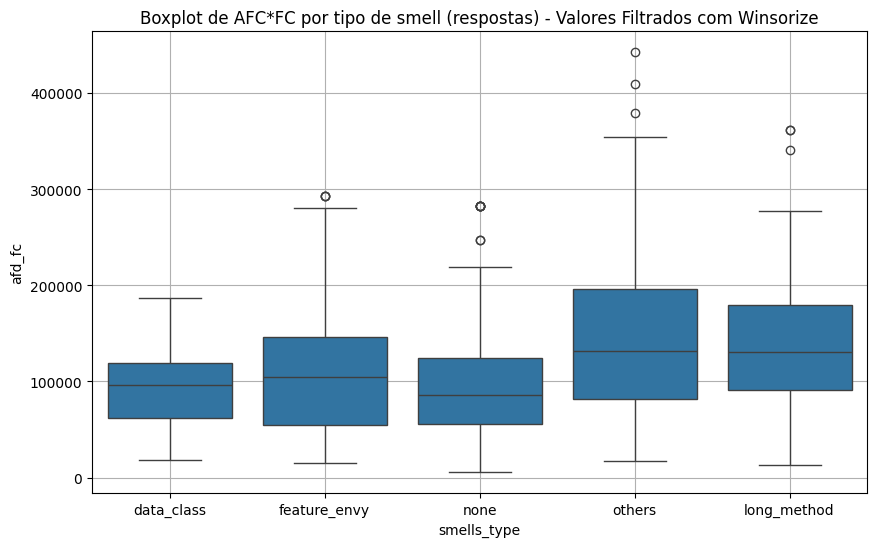

In [57]:
lm = pd.DataFrame(index=['long_method' for i in range(len(long_method_treated))], data=long_method_treated.values).reset_index()
lm.columns = ['smells_type', 'afd_fc']

dc = pd.DataFrame(index=['data_class' for i in range(len(data_class_treated))], data=data_class_treated.values).reset_index()
dc.columns = ['smells_type', 'afd_fc']

fe = pd.DataFrame(index=['feature_envy' for i in range(len(feature_envy_treated))], data=feature_envy_treated.values).reset_index()
fe.columns = ['smells_type', 'afd_fc']

no = pd.DataFrame(index=['none' for i in range(len(none_treated))], data=none_treated.values).reset_index()
no.columns = ['smells_type', 'afd_fc']

others = pd.DataFrame(index=['others' for i in range(len(others_treated))], data=others_treated.values).reset_index()
others.columns = ['smells_type', 'afd_fc']

smells_afd_fc_res = pd.concat([lm, dc, fe, no, others])

# Plotar o boxplot filtrado com os limites ajustados
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='smells_type', y='afd_fc', data=smells_afd_fc_res,
            order=['data_class', 'feature_envy', 'none', 'others', 'long_method'])
plt.title('Boxplot de AFC*FC por tipo de smell (respostas) - Valores Filtrados com Winsorize')
plt.grid()

plt.show()

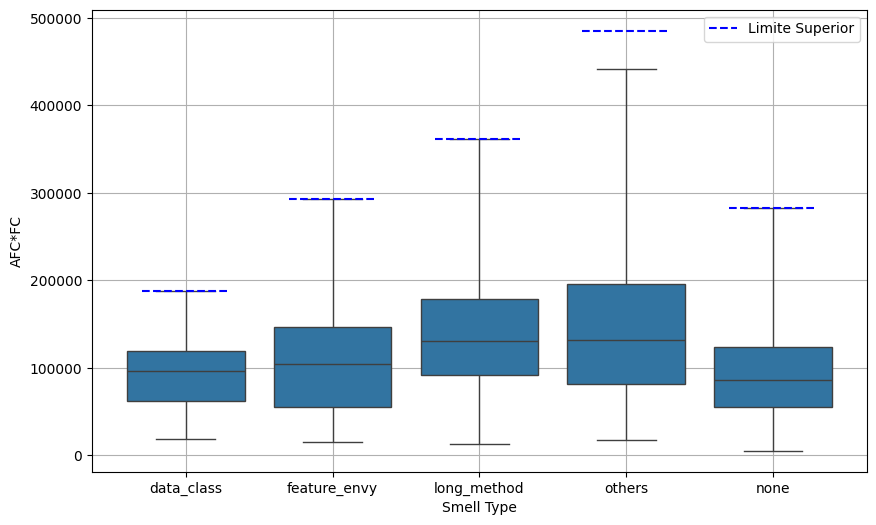

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='smells_type', y='afd_fc', data=smells_afd_fc_res,
            order=['data_class', 'feature_envy', 'long_method', 'others', 'none'], whis=100)
plt.xlabel('Smell Type')
plt.ylabel('AFC*FC')
# plt.xticks(['Data Class', 'Feature Envy', 'Long Method', 'None', 'Others', 'None'])

# plt.title('Boxplot de AFC*FC por tipo de smell (respostas) - Valores Filtrados com Winsorize')
plt.grid()

for i, smell in enumerate(['data_class', 'feature_envy', 'long_method', 'others', 'none']):
    upper = adjusted_limits[smell]['upper']

    # Adiciona as linhas de limite ajustado
    ax.hlines(y=upper, xmin=i - 0.3, xmax=i + 0.3, colors='blue', linestyles='--', label='Limite Superior' if i == 0 else "")

plt.legend()

plt.show()

### Teste para verificar igualdade de variância

    H0: Não há diferenças significativas na variância da métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que foram
    identificados como smell e códigos não identificados como smell.

    H1: Há diferenças significativas na variância da métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que
    foram identificados como smell e códigos não identificados como smell.

In [59]:
statistic, pvalue = levene(no_smell_afd_fc, smell_afd_fc)

print(f"stat: {statistic}")
print(f"pvalue: {pvalue}")

alpha = 0.05

if pvalue < alpha:
    print("H0 rejeitada. As variâncias são diferentes.")
else:
    print("H0 não rejeitada. As variâncias são iguais.")

stat: 5.109133103589268
pvalue: 0.024489208028196534
H0 rejeitada. As variâncias são diferentes.


### Teste para verificar a diferença:

    H0: Não há diferenças significativas na métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que foram
    identificados como smell e códigos não identificados como smell.

    H1: Há diferenças significativas na métrica FC*AFD (Fixation Count * Average Fixation Duration (AFD)) entre códigos que
    foram identificados como smell e códigos não identificados como smell.

In [60]:
# statistic, pvalue = ttest_ind(smell_afd_fc, no_smell_afd_fc)
statistic, pvalue = mannwhitneyu(smell_afd_fc, no_smell_afd_fc)

print(f"U-statistic: {statistic}")
print(f"p-value: {pvalue}")

alpha = 0.05

if pvalue < alpha:
    print("H0 rejeitada. Há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.")
else:
    print("H0 não rejeitada. Não há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.")


U-statistic: 15290.0
p-value: 0.00018215236372934822
H0 rejeitada. Há diferenças significativas na métrica FC*AFD entre códigos que foram identificados como smell e códigos não identificados como smell.


### ANOVA e Tukey's Test

In [61]:
long_method_res_afd_fc = long_method_treated
data_class_res_afd_fc = data_class_treated
feature_envy_res_afd_fc = feature_envy_treated
none_res_afd_fc = none_treated
others_res_afd_fc = others_treated

f_stat, p_valor = f_oneway(long_method_res_afd_fc, data_class_res_afd_fc, feature_envy_res_afd_fc, none_res_afd_fc)
print(f"Estatística F: {f_stat}, p-valor: {p_valor}")

alfa = 0.05

if p_valor < alfa:
    dados = np.concatenate([long_method_res_afd_fc, data_class_res_afd_fc, feature_envy_res_afd_fc, none_res_afd_fc, others_res_afd_fc])
    grupos = (['Long Method'] * len(long_method_res_afd_fc) + ['Data Class'] * len(data_class_res_afd_fc) \
              + ['Feature Envy'] * len(feature_envy_res_afd_fc) + ['None'] * len(none_res_afd_fc) + \
              ['Others'] * len(others_res_afd_fc))

    tukey = pairwise_tukeyhsd(endog=dados, groups=grupos, alpha=alfa)
    print(tukey)
else:
    print("Não há diferença significativa entre as médias dos grupos (p >= alfa).")

Estatística F: 5.8266266307393, p-valor: 0.0007218049482484713
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
   group1       group2      meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------------------
  Data Class Feature Envy  22947.3293 0.7015 -26107.3761  72002.0348  False
  Data Class  Long Method  46419.8381 0.0369   1798.7858  91040.8904   True
  Data Class         None   2215.4357 0.9998 -35441.3831  39872.2546  False
  Data Class       Others  59478.7825 0.0031  14451.1268 104506.4382   True
Feature Envy  Long Method  23472.5088 0.6307 -22663.6466  69608.6641  False
Feature Envy         None -20731.8936 0.6007 -60172.2603  18708.4731  False
Feature Envy       Others  36531.4532 0.2001  -9998.0675  83060.9739  False
 Long Method         None -44204.4024 0.0035 -77971.4974 -10437.3074   True
 Long Method       Others  13058.9444 0.9123 -28770.1182   54888.007  False
        None       Others